<a href="https://colab.research.google.com/github/HJGuan/UZH_FDS/blob/main/Practical1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
pd.options.display.max_columns = None
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as sm
import statsmodels
from sklearn.linear_model import LinearRegression


# Practical 1 : Implementation of Linear Regression (Ridge, Lasso)

First part:
- Implement linear regression model 
    - using least squares method
    - implement directly using the NumPy package

Second part:
- regularization
- polynomial basis expansion
- cross validation
- scikit-learn: https://scikit-learn.org/

You will need to use the following:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cp

For the purpose of testing, we’ll use the winequality dataset. The dataset is available here:
https://archive.ics.uci.edu/ml/datasets/Wine+Quality In order to make it easier to import the dataset, we’ve converted the data to the numpy array format and shuffled it so that you can start the practical directly. The dataset is available on the course website. 

The dataset has two files. We’ll focus on the white wine data, which is the larger dataset. You can load the data from the files as follows:

In [ ]:
# load the dataset
# X is a matrix such that each row stores a data record 
# y is a vector of the corresponding labels of the records
X, y = cp.load(open('winequality-white.pickle', 'rb'))

# check the size of the data
print("X is a matrix with shape {}, which has {} records and {} attributes.".format(X.shape, X.shape[0], X.shape[1]))
print("y is a vector with {} values, which stores the corresponding labels of the data records in X".format(y.shape[0]))


X is a matrix with shape (4898, 11), which has 4898 records and 11 attributes.
y is a vector with 4898 values, which stores the corresponding labels of the data records in X


In order to get consistent results, all students should use the same 80% of the data as training
data. We’ll use the remaining as test data. To achieve this split run the following:

In [ ]:
# The function splits the dataset into the training dataset and the test dataset.
# The parameter split_coeff is a percentage value such that
# the first split_coeff of the dataset goes to the training dataset, 
# and the remaining data goes to the test dataset.


def split_data(X, y, split_coeff):
    N, _ = X.shape # get the number of records (rows)
    train_size = int(split_coeff * N) # use the first split_coeff of the data as the training data
    X_train = X[:train_size] # the first training_size records
    y_train = y[:train_size]
    X_test = X[train_size:] # the last test_size records
    y_test = y[train_size:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(X, y, 0.8) # use 80% of the data as training data

# check the size of the splitted dataset
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3918, 11)
Shape of y_train: (3918,)
Shape of X_test: (980, 11)
Shape of y_test: (980,)


We’ll not touch the test data except for reporting the errors of our learned models

## Understanding What We’re Predicting

Before we get to training a linear model on the data and using it to make predictions, let’s look
at the spread of y values on the training set. The values are integers between 3 and 9 indicating
the quality of the wine.


### **Task 1**
Make a bar chart showing the distribution of y values appearing in the training data.

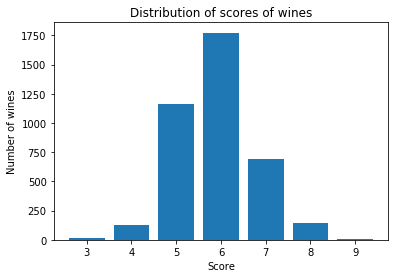

In [ ]:
#@title
# Task 1: 
# the function takes the training dataset as the input, and make the bar chart
def plot_bar_chart_score(X_train, y_train):
    c=Counter(y_train)
    plt.figure()
    plt.bar(c.keys(),c.values())
    plt.title("Distribution of scores of wines")
    plt.xlabel("Score")
    plt.ylabel("Number of wines")
    return plt.show()

plot_bar_chart_score(X_train, y_train)

### **Task 2** 
Implement the trivial predictor, which uses the average value of y on the training set as the prediction for ever datapoint. 

In [ ]:
#@title
# Task 2: implement the simplest predictor
# The function computes the average value of y on the training label values
def compute_average(y_train):
    avg=np.mean(y_train)
    return avg

y_train_avg = compute_average(y_train)
print("Average of y on the training label values is {}".format(y_train_avg))

# The simplest predictor returns the average value.
def simplest_predictor(X_test, y_train_avg):
    return y_train_avg

Average of y on the training label values is 5.878764675855028


### **Task 3**
Report the mean squared error, i.e., the average of the squared residuals, using this simplest of predictors on the training and test data. We should hope that our models beat at lease this baseline. 

In [ ]:
def simplest_predictor(X_test, y_train_avg):
    return y_train_avg

In [ ]:
# We will evaluate our simplest predictor here. 
# Implement a function that can report the mean squared error 
# of a predictor on the given test data
# Input: test dataset and predictor
# Output: mean squared error of the predictor on the given test data
def test_data(X_test, y_test, predictor: callable=None):
    # Applies the predictor to each row to compute the predicted values
    y_predicted = np.apply_along_axis(predictor, 1, X_test)
    mse=np.mean((y_test-y_predicted)**2)
    return mse

# use the above function test_data to evaluate the simplest predictor
# we use the lambda function here to pass the function simplest_predictor to the evaluator.
mse_simplest_predictor_train = test_data(X_train, y_train, lambda x: simplest_predictor(x, y_train_avg))
mse_simplest_predictor_test = test_data(X_test, y_test, lambda x: simplest_predictor(x, y_train_avg))

# Report the result
print('Simplest Predictor')
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_simplest_predictor_train)
print('MSE (Testing)  = %.4f' % mse_simplest_predictor_test)

Simplest Predictor
--------------------------------------------------------------------------------

MSE (Training) = 0.7768
MSE (Testing)  = 0.8139


## Linear Model Using Least Squares

Let us first fit a linear regression model and then calculate the training and test error. We’ll
actually use the closed form solution of the least squares estimate for the linear model. 


### **Task 4**
Is it strictly necessary to standardize the data for the linear model using the least squares method? Why?

No, it is not strictly nescessary. It depends on whether, after regression, we want to conduct other analysis that strictly requires the features to be fit to normal distribution or in which cases different scales of features will mislead us, such as PCA(Principle Component Analysis). Otherwise, sololy Linear regression using least squares method does not require standardization.

We consider the model as $$y=\beta_0+\beta_1x1+\beta_2x2+\beta_3x3+...+\epsilon\tag{1}$$
and according to the least squares method, the slope coefficients are: (using $\beta_1$ as exemple)  $$\hat{\beta}_1(x_1)=\frac{\sum^n_{i=1}(x_{1,i}-\bar{x}_1)(y_i-\bar{y})}{\sum^n_{i=1}(x_{1,i}-\bar{x}_1)^2}\tag{2}$$

Standardization stands for: $$x\prime=\frac{x-\mu}{\sigma}$$ which we can see as seperately **Centering** and **Scaling**. **Centering** will not influence the slopes:

$$\hat{\beta}'_1(x_1)=\frac{\sum^n_{i=1}((x'_{1,i}-\mu)-0)(y_i-\bar{y})}{\sum^n_{i=1}((x'_{1,i}-\mu)-0)^2}=\frac{\sum^n_{i=1}(x_{1,i}-\bar{x}_1)(y_i-\bar{y})}{\sum^n_{i=1}(x_{1,i}-\bar{x}_1)^2}=\hat{\beta}_1(x_1)\tag{3}$$

We can find that **Centering** do not influence the sums of residuals, hence neither the slope coefficients. The only variable being influenced in fomula (1) is $\beta_0$, which is the intersect, because **Centering** moves the data horizonaly.

The effect on regression given by **Scaling** is that the slopes will change propotionaly (If we multiply $x_n$ a facter $\frac{1}{\sigma}$ for exemple, we will simply change the $\hat\beta_1$ into $\frac{\hat\beta_1}{\sigma}$).

$$\hat{\beta}_1(\frac{x_1}{\sigma})=\frac{\sum^n_{i=1}(\frac{1}{\sigma}x_{1,i}-\frac{1}{\sigma}\bar{x}_1)(y_i-\bar{y})}{\sum^n_{i=1}(\frac{1}{\sigma}x_{1,i}-\frac{1}{\sigma}\bar{x}_1)^2}=\frac{\frac{1}{\sigma}\sum^n_{i=1}(x_{1,i}-\bar{x}_1)(y_i-\bar{y})}{(\frac{1}{\sigma})^2\sum^n_{i=1}(x_{1,i}-\bar{x}_1)^2}=\frac{\hat{\beta}_1(x_1)}{\sigma}$$

The validity of the regression model is not influenced by whether we conduct standardization or not. However, the slope coeffients $\beta_n, (n\geqslant1)$ are used to represent the marginal effects on $y_n$ given by one additional unit of $x_n$. Standardization will make it hard for user to identify these marginal effects.

### **Task 5**
Standardize the data, i.e., make the data for every feature have mean 0 and variance 1. 

We do the standardization using the training data, and we need to remember the means and
the standard deviations so that they can be applied to the test data as well. Apply the
standardization so that every feature in the training data has mean 0 and variance 1. Apply
the same transformation to the test data. 

In [ ]:
# Input: training data
# Output: standardize training data, standard deviations and means
def standardize_data(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_std = (X-mean)/std
    return X_std, mean, std

X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)

print("The shape of X_train_std:", X_train_std.shape)
print("Mean:", X_train_mean)
print("Standard deviation:", X_train_std_div)

The shape of X_train_std: (3918, 11)
Mean: [6.85427514e+00 2.78390761e-01 3.34892802e-01 6.42623788e+00
 4.58213374e-02 3.53263144e+01 1.38513272e+02 9.94040729e-01
 3.18647524e+00 4.89055641e-01 1.05115799e+01]
Standard deviation: [8.39100902e-01 9.95630176e-02 1.24249975e-01 5.06377532e+00
 2.16660282e-02 1.71004677e+01 4.23956179e+01 2.97972269e-03
 1.49949475e-01 1.12992053e-01 1.22536544e+00]


In [ ]:
# TODO: Standardize the test data using the mean and standrad deviation you computed for the training data

X_test_std, X_test_mean, X_test_std_div = standardize_data(X_test)

print("The shape of X_test_std:", X_test_std.shape)
print("Mean:", X_test_mean)
print("Standard deviation:", X_test_std_div)

The shape of X_test_std: (980, 11)
Mean: [6.85683673e+00 2.77642857e-01 3.31387755e-01 6.25219388e+00
 4.55765306e-02 3.52352041e+01 1.37750510e+02 9.93973995e-01
 3.19542857e+00 4.93010204e-01 1.05250102e+01]
Standard deviation: [8.62240315e-01 1.05523501e-01 1.07021420e-01 5.10008981e+00
 2.25488418e-02 1.66196968e+01 4.28782894e+01 3.03311801e-03
 1.54849894e-01 1.18441495e-01 1.25073461e+00]


### **Task 6**
Implement the linear model predictor, and report the mean squared error using the linear model on the training and test data.

We will do this in several steps. We need to implement the function for computing the parameters based on the training dataset. Note we need to add the bias column to the dataset. 

In [ ]:
# the function adds a column of ones to the front of the input matrix
def expand_with_ones(X):
    add = np.ones(X.shape[0])
    X_out = np.insert(X,0,values=add,axis=1)
    return X_out


# The function computes the parameters
def least_squares_compute_parameters(X_input, y):
    model=LinearRegression()
    #X_input=expand_with_ones(X_input)
    lr=model.fit(X_input,y)
    T = np.insert(lr.coef_,0,values=lr.intercept_,axis=0)
    return T


# train the linear model parameters
w = least_squares_compute_parameters(X_train_std, y_train) 
print(w)
print(type(w))
print("w:", w.shape)

[ 5.87876468e+00  5.70365710e-02 -1.83384219e-01 -4.04067444e-03
  4.09097280e-01 -8.17517111e-03  5.92929519e-02 -3.56633675e-03
 -4.36936781e-01  9.87381161e-02  6.53325059e-02  2.42495455e-01]
<class 'numpy.ndarray'>
w: (12,)


We then implement the linear model predictor given the dataset and the parameters. 

In [ ]:
# Implement the linear model predictor
# Input: test data and parameters
# Output: predicted values
def linear_model_predictor(X, w):
    # TODO: compute the predicted values based on the test dataset and the parameters
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    Y=X.dot(w)
    return Y

In [ ]:
y_predicted=linear_model_predictor(expand_with_ones(X_test_std),w)

We can now evaluate our linear model predictor on the test dataset. 

In [ ]:
def test_data(X_test, y_test, predictor: callable=None):
    # Applies the predictor to each row to compute the predicted values
    y_predicted = np.apply_along_axis(predictor, 1, X_test)
    mse=np.mean((y_test-y_predicted)**2)
    return mse

In [ ]:
# use the function test_data to evaluate the linear model predictor
mse_linear_model_predictor = test_data(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
print("Mean squared error is {}".format(mse_linear_model_predictor))

Mean squared error is 0.562066730662596


## Learning Curves

Let us see if the linear model is overfitting or underfitting. Since the dataset is somewhat large and there are only 11 features, our guess should be that it may either be underfitting or be about right.

Starting with 20 datapoints, we’ll use training datasets of increasing size, in increments of 20 up to about 600 datapoints. For each case train the linear model only using the first n elements of
the training data. Calculate the training error (on the data used) and the test error (on the full test set). Plot the training error and test error as a function of the size of the dataset used for
training.

### **Task 7** 
Implement a function that evaluates the linear model over the training dataset with the input size.
The function takes a dataset and the split coefficient as inputs, and
1. splits the data to training and test datasets,
2. standardizes the data,
3. trains the linear model, and
4. reports the mse of the linear model predictor on both training and test datasets. 

In [ ]:
# Input: dataset and split coefficient
# Output: mse of the linear model predictor on both the training and test datasets
def train_and_test(X, y, split_coeff):
    X_train, y_train, X_test, y_test = split_data(X, y, split_coeff)#splits the data to training and test datasets
    X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)#standardizes the data
    X_test_std, X_train_mean, X_train_std_div = standardize_data(X_test)#The test data must be standardized using the means and standard deviations of the training data.
    w=least_squares_compute_parameters(X_train_std, y_train)#trains the linear model
    mse_train=test_data(expand_with_ones(X_train_std), y_train, lambda x: linear_model_predictor(x, w))#reports the mse
    mse_test=test_data(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
    return mse_train, mse_test
 

mse_train, mse_test = train_and_test(X, y, 0.8)
print('MSE using Linear Models')
print('-----------------------\n')
print('MSE (Training) = %.4f' % mse_train)
print('MSE (Testing)  = %.4f' % mse_test)


MSE using Linear Models
-----------------------

MSE (Training) = 0.5640
MSE (Testing)  = 0.5621


### **Task 8**
Report the learning curves plot. Also, explain whether you think the model is underfitting or not and how much data you need before getting the optimal test error.

In [ ]:
mse_train_v = []
mse_test_v = []

TRAINING_SIZE_MAX = 601
TRAINING_SIZE_MIN = 20

for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20):
    X_train_std_seg=X_train_std[0:train_size,:]
    y_train_seg=y_train[0:train_size]
    w=least_squares_compute_parameters(X_train_std_seg, y_train_seg)#trains the linear model
    mse_train=test_data(expand_with_ones(X_train_std), y_train, lambda x: linear_model_predictor(x, w))#reports the mse
    mse_test=test_data(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
    mse_train_v.append(mse_train)
    mse_test_v.append(mse_test)
    
print(mse_train_v)
print(mse_test_v)

[2.591451963821953, 1.0586081059986376, 0.7404532782723247, 0.6483983901495343, 0.6346141759675119, 0.6252353903942954, 0.6128068429123744, 0.603780361724681, 0.6012739864472627, 0.5905716023431327, 0.5813254164395628, 0.5886948363832406, 0.5819047521356662, 0.5758064837753777, 0.5744882467864655, 0.575108349378868, 0.575850843805667, 0.5736755576612952, 0.5722746936820732, 0.5727046843235217, 0.5747051861531355, 0.5732305028980075, 0.5711274388114163, 0.5681750565984991, 0.5676869837018916, 0.5677489612704077, 0.5674672143839286, 0.5681975753232306, 0.5684629257082594, 0.5695824711481706]
[2.5612228528060452, 1.0823927360354921, 0.7578268033236155, 0.6521303333348949, 0.622750241220382, 0.6221086637802614, 0.6061816109800403, 0.5958588977063082, 0.5889026721782317, 0.5808931830613379, 0.5773928145485333, 0.5835939586159932, 0.577662080760088, 0.5695707089967706, 0.5685228779959929, 0.5715142773395018, 0.5707238469882586, 0.5682709202736604, 0.5674115464684686, 0.5673828284666277, 0.56

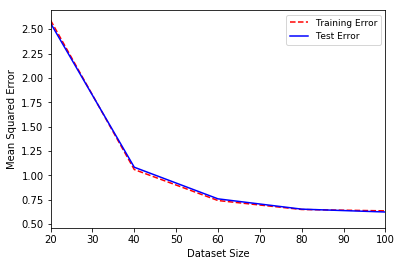

In [ ]:
# The below code outputs the plot of mse from different training sizes
plt.figure(2)
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_v, 'r--', label="Training Error")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_v, 'b-', label="Test Error")
plt.legend(loc='upper right', fontsize=9)
plt.xlim(20,100)
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error')
plt.show()

(Add the answer to Task 8 here in text)




just about right

## Polynomial Basis Expansion with Ridge and Lasso

For this part use the following from the scikit-learn package. Read the documentation available here: http://scikit-learn.org/stable/modules/classes.html



You will need the use the following:

In [ ]:
# You will need the following libs. 
# feel free to import other libs. 

# import the preprocessing libs for standarization and basis expansion
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 

# Ridge and Lasso linear model
from sklearn.linear_model import Ridge, Lasso 
from sklearn.metrics import mean_squared_error

Try 5 powers of 10 for lambda from 10^-2 to 10^2 and use degree 2 basis expansion. Fit ridge and lasso using degree 2 polynomial expansion with these values of lambda. You should pick the optimal values for lambda using a validation set. Set the last 20% of the training set for the purpose of validation.

### **Task 9**
Let's implement the function for expanding the basis of the dataset. 

Hints: use `PolynomialFeatures`

In [ ]:
def expand_basis(X, degree):
    poly = PolynomialFeatures(degree)
    X_expanded = poly.fit_transform(X)
    return X_expanded


In [ ]:
X_expanded=expand_basis(X, 2)

### **Task 10**
Prepare the training, test and validation data using the expanded dataset. Expand and standardize the the data. 

Hints: you can use `StandardScaler` and `std_scaler` to standardize the data

In [ ]:
def standardize(X):
    scaler=StandardScaler()
    scaler.fit(X)
    X_scale=scaler.transform(X,copy=None)
    return X_scale

In [ ]:
N, _ = X.shape
print(int(N*0.8*0.8))

3134


In [ ]:
# TODO: the training, test and validation data using the expanded dataset.
def prepare_data(X, y, degree):
    # Hints: follow the steps    
    # You need to parpare four datasets:
    # 1. training data -- X_train, y_train
    # 2. test data -- X_test, y_test
    # 3. validation data -- X_train_v, y_train_v
    # 4. training data (cross validation) -- X_train_n, y_train_n
    X_exp=expand_basis(X, degree)
    X_exp_std=standardize(X_exp)
    # training data
    N, _ = X.shape # get the number of records (rows)
    train_size = int(0.8 * N) # use the first split_coeff of the data as the training data
    X_train = X_exp_std[:train_size] 
    y_train = y[:train_size]
    # test data
    X_test = X_exp_std[train_size:]
    y_test = y[train_size:]

    # further split the training data to training and validation data
    # training data
    n, _ = X_train.shape # get the number of records (rows)
    train_n_size = int(0.8 * n)
    X_train_n = X_train[:train_n_size] 
    y_train_n = y_train[:train_n_size] 

    # validation data
    X_train_v = X_train[train_n_size:] 
    y_train_v = y_train[train_n_size:]

    return X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test


X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 2) # here we expand the dataset with degree 2

### **Task 11**
We have prepared the training data and the validation data. We can now choose the hyper parameter lambda for Ridge and Lasso using the validation data. 


Ridge lambda: 0.01
Lasso lambda: 0.01


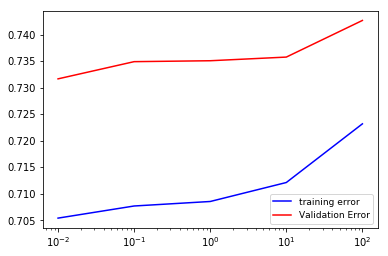

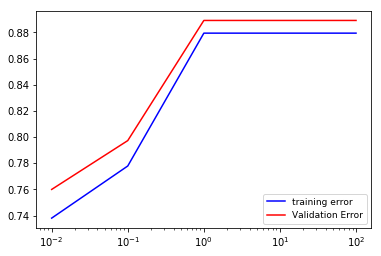

In [ ]:
# The function takes the training and validation data as inputs, and 
# returns the lambda value that has the minimal mse
# We use is_ridge to indicate the model we consider. 
# is_ridge = True indicates Ridge while is_ridge = False indicates Lasso
def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, is_ridge: bool,lam_begin,lam_end):
    mse_arr_n = []
    mse_arr_v = []
    lam_arr = []
    # Try lambda values from 10^-2 to 10^2. 
    # Record the mse and the lambda values in mse_arr and lam_arr
    for pow_lam in range(lam_begin, lam_end+1):
        lam = 10 ** pow_lam
        if is_ridge==True:
            reg = Ridge(alpha=lam)
            reg.fit(X_train_n,y_train_n) 
        else:
            reg = Lasso(alpha=lam)
            reg.fit(X_train_n,y_train_n) 
        mse_n=np.sqrt(mean_squared_error(y_train_n,reg.predict(X_train_n)))
        mse_v=np.sqrt(mean_squared_error(y_train_v,reg.predict(X_train_v)))
        mse_arr_n.append(mse_n) # add the mse when using the hyperparameter lam
        mse_arr_v.append(mse_v)
        lam_arr.append(lam)
    # get the index of the lambda value that has the minimal use
    lambda_idx_min = np.argmin(np.array(mse_arr_v))
    # print(lam_arr[lambda_idx_min])

    # plot of the lambda values and their mse
    plt.figure()
    plt.semilogx(lam_arr, mse_arr_n,'b-', label="training error")
    plt.semilogx(lam_arr, mse_arr_v,'r-', label="Validation Error")
    plt.legend(loc='lower right', fontsize=9)


    # return the best lambda value
    return lam_arr[lambda_idx_min]

# call the function to choose the lambda for Ridge and Lasso
lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True,-2,2)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False,-2,2)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

### **Task 12**:
Once you’ve obtained the optimal values for lambda for Ridge and Lasso, train these models using these hyperparameters on the full training data. Then report
the training and test error.

In [ ]:
# TODO: train the Ridge and Lasso models using their best parameters, and
#       report their mse


def get_mse(x,y,l,lam):
    if l==1:
        reg=Lasso(alpha=lam)
        reg.fit(x,y)
        mse=np.sqrt(mean_squared_error(y,reg.predict(x)))
    elif l==2:
        reg=Ridge(alpha=lam)
        reg.fit(x,y)
        mse=np.sqrt(mean_squared_error(y,reg.predict(x)))
    else:
        pass
    return mse


mse_ridge_train = get_mse(X_train,y_train,2,lam_ridge)
mse_ridge_test = get_mse(X_test,y_test,2,lam_ridge)
mse_lasso_train = get_mse(X_train,y_train,1,lam_lasso)
mse_lasso_test = get_mse(X_test,y_test,1,lam_lasso)


# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (lam_ridge, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (lam_lasso, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression with using degree 0 polynomial expansion and lambda = 0.0100
--------------------------------------------------------------------------------

MSE (Training) = 0.7081
MSE (Testing)  = 0.6752


For Lasso with using degree 0 polynomial expansion and lambda = 0.0100
---------------------------------------------------------------------

MSE (Training) = 0.7409
MSE (Testing)  = 0.7196


C:\Users\Guan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


## Larger Degrees



### **Task 13**
Try using higher degree basis expansion. You may want to use k-fold cross validation to determine
the values of hyperparameters rather than just keeping a validation set. 

Hints: Use `KFold` to do this automatically. 

In [ ]:
# KFold
from sklearn.model_selection import KFold
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# here we expand the dataset with degree 4
X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 4) 

In [ ]:
X_train.shape

(3918, 1365)

C:\Users\Guan\Anaconda3\lib\site-packages\sklearn\linear_model\ridge.py:125: LinAlgWarning: Ill-conditioned matrix (rcond=1.67465e-17): result may not be accurate.
  overwrite_a=True).T
C:\Users\Guan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Guan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\Guan\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  

Ridge lambda: 10
Lasso lambda: 0.001


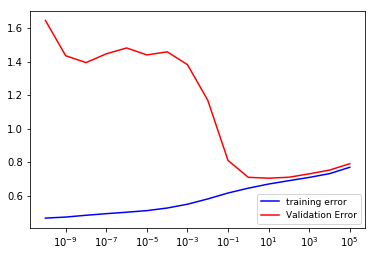

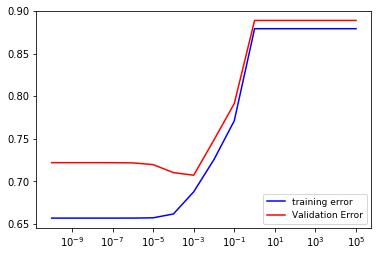

In [ ]:
# the original way
from warnings import filterwarnings
filterwarnings('ignore')

lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True,-10,5)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False,-10,5)
print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

Ridge lambda: 10
Lasso lambda: 0.001


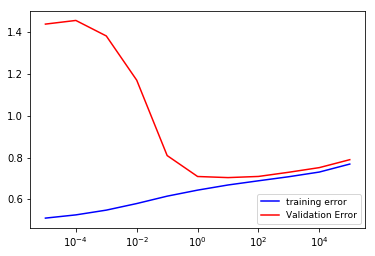

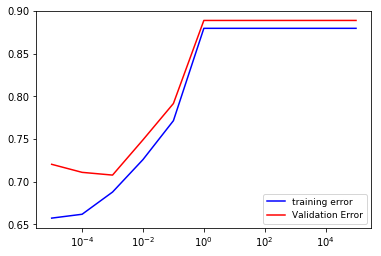

In [ ]:
# using k-fold cross-validation
from warnings import filterwarnings
filterwarnings('ignore')

def choose_hyperparam_with_Kfold_validation(X_train,y_train,lam_begin, lam_end, is_ridge:bool,K):
    # Code that triggers the warning
    mse_arr_n = []
    mse_arr_v = []
    lam_arr = []
    for pow_lam in range(lam_begin, lam_end+1):
        lam = 10 ** pow_lam
        kf = KFold(n_splits=K,shuffle=False)
        mse_ns = []
        mse_vs = []
        for n_idx, v_idx in kf.split(X_train):
            X_train_n, X_train_v= X_train[n_idx],X_train[v_idx]
            y_train_n, y_train_v= y_train[n_idx],y_train[v_idx]
            if is_ridge==True:
                reg = Ridge(alpha=lam)
                reg.fit(X_train_n,y_train_n) 
            else:
                reg = Lasso(alpha=lam)
                reg.fit(X_train_n,y_train_n) 
            mse_n=np.sqrt(mean_squared_error(y_train_n,reg.predict(X_train_n)))
            mse_v=np.sqrt(mean_squared_error(y_train_v,reg.predict(X_train_v)))    
            mse_ns.append(mse_n) 
            mse_vs.append(mse_v)
        mse_n_avg,mse_v_avg= np.mean(mse_ns), np.mean(mse_vs)
        mse_arr_n.append(mse_n)
        mse_arr_v.append(mse_v)
        lam_arr.append(lam)
    plt.figure()
    plt.semilogx(lam_arr, mse_arr_n,'b-', label="training error")
    plt.semilogx(lam_arr, mse_arr_v,'r-', label="Validation Error")
    plt.legend(loc='lower right', fontsize=9)
    lambda_idx_min = np.argmin(np.array(mse_arr_v))
    return lam_arr[lambda_idx_min]

lam_ridge = choose_hyperparam_with_Kfold_validation(X_train,y_train,-5, 5, True, 5)
lam_lasso = choose_hyperparam_with_Kfold_validation(X_train,y_train,-5, 5, False, 5)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

In [ ]:
def get_mse(x,y,l,lam):
    if l==1:
        reg=Lasso(alpha=lam)
        reg.fit(x,y)
        mse=np.sqrt(mean_squared_error(y,reg.predict(x)))
    elif l==2:
        reg=Ridge(alpha=lam)
        reg.fit(x,y)
        mse=np.sqrt(mean_squared_error(y,reg.predict(x)))
    else:
        pass
    return mse



mse_ridge_train = get_mse(X_train,y_train,2,lam_ridge)
mse_ridge_test = get_mse(X_test,y_test,2,lam_ridge)
mse_lasso_train = get_mse(X_train,y_train,1,lam_lasso)
mse_lasso_test = get_mse(X_test,y_test,1,lam_lasso)


# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (lam_ridge, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (lam_lasso, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression with using degree 10 polynomial expansion and lambda = 10.0000
--------------------------------------------------------------------------------

MSE (Training) = 0.6711
MSE (Testing)  = 0.6330


For Lasso with using degree 0 polynomial expansion and lambda = 0.0010
---------------------------------------------------------------------

MSE (Training) = 0.6902
MSE (Testing)  = 0.6403


# Practical 1 Report

In this practical, we had learnt how to:

>**1.implement linear regression using least squared errors methods from scratch**                         
**2.recognize underfitting and overfitting problems**                        
**3.solve overfitting problem with Ridge, Lasso regression utilizing the library SKlearn **

The most difficult part for us is to create a overfitting model. With the help of the lecture notes and document of SKlearn, we had understood details on basis expension and tried multiple higher degree basis expension. In task 13 above, we showed basis expension with a degree of 4, since with degree of 3, we think the overfitting is not obvious enough but with degree of 5, our features number would be too large comparative to our data amount. To fully show the change of validation error and training error, we also chose the hyperparameter $\lambda$ from $10^{-5}$ to $10^5$. 

Upon the contribution of each menber, we first coded our own answers and then we figured out the final solution through discussion. So we all contributed nearly the same.


Hongjie, Yilan, Tinghuan


